In [1]:
ban=0
batch_size=4

In [2]:
import torch
cuda_num = str(2)
device_s = "cuda:" + cuda_num
device0 = torch.device(device_s if torch.cuda.is_available() else "cpu")

cuda_num_test = str(7)
device_s = "cuda:" + cuda_num_test
device1 = torch.device(device_s if torch.cuda.is_available() else "cpu")

In [3]:
# 读数据
import pandas as pd
df_train=pd.read_excel("../data/df_train.xlsx",index_col=0)
df_test=pd.read_excel("../data/df_test.xlsx",index_col=0)

In [4]:
import ast
for i in range(len(df_train)):
    new_list=[]
    old_list=ast.literal_eval(df_train.loc[i]['label'])
    for j in old_list:
        if j==0:
            new_list+=[0,0,0]
        if j==1:
            new_list+=[0,0,1]
        if j==2:
            new_list+=[0,1,1]
        if j==3:
            new_list+=[1,1,1]

    df_train.loc[i]['label']=new_list

In [5]:
for i in range(len(df_test)):
    new_list=[]
    old_list=ast.literal_eval(df_test.loc[i]['label'])
    for j in old_list:
        if j==0:
            new_list+=[0,0,0]
        if j==1:
            new_list+=[0,0,1]
        if j==2:
            new_list+=[0,1,1]
        if j==3:
            new_list+=[1,1,1]
        
    df_test.loc[i]['label']=new_list

In [6]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
df_train_text=[df_train['text'][i] for i in range(len(df_train))]
df_test_text=[df_test['text'][i] for i in range(len(df_test))]


In [7]:
text2id_train = tokenizer(
        df_train_text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
input_ids_train=text2id_train["input_ids"]
mask_train=text2id_train["attention_mask"]

text2id_test = tokenizer(
        df_test_text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
input_ids_test=text2id_test["input_ids"]
mask_test=text2id_test["attention_mask"]


In [8]:
df_train['input_ids']=input_ids_train.tolist()
df_train['mask']=mask_train.tolist()

df_test['input_ids']=input_ids_test.tolist()
df_test['mask']=mask_test.tolist()

In [9]:
from torch.utils.data import Dataset
class SentimentDataset(Dataset):
    def __init__(self,df):
        self.dataset = df
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        text = self.dataset.loc[idx, "text"]
        label = self.dataset.loc[idx, "label"]
#         print(label)
        input_ids = self.dataset.loc[idx, "input_ids"]
        mask = self.dataset.loc[idx, "mask"]
        sample = {"text": text, "label": label,"input_ids":input_ids,"mask":mask}
        # print(sample)
        return sample

In [10]:
#按batch_size分
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import torch

train_loader = DataLoader(
    SentimentDataset(df_train), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)
print(train_loader)

test_loader = DataLoader(
    SentimentDataset(df_test), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)
print(test_loader)

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F


class fn_cls(nn.Module):
    def __init__(self,device):
        super(fn_cls, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-chinese")
        self.model.to(device)
        self.dropout = nn.Dropout(0.5)
        self.l1 = nn.Linear(768, 18)
#         self.l2 = nn.Linear(768, 6)

    def forward(self, x, attention_mask=None):
        outputs = self.model(x, attention_mask=attention_mask)
#         print(outputs[0])torch.Size([8, 100, 768])
#         print(outputs[1])torch.Size([8, 768])
#         print(outputs[0][:,0,:])torch.Size([8, 768])
#         print(outputs[1])torch.Size([8, 768])
        x = outputs[1]
        x = self.dropout(x)
        x = self.l1(x)
        return x

In [12]:
def _18to6_(output,round_=0):#18tensor 变 6list
    output0=[]
    for j in output:#18
        i=0
        s=''
        list6=[]
        while(i<len(j)):
            ok=j[i]*1.2+j[i+1]*1.1+j[i+2]*1
            if round_==1:
                list6.append(ok.round().int().tolist())
            else:
                list6.append(ok.tolist())
            i+=3
        output0.append(list6)
    return output0

def get_loss_test(output,A,round_=0):#8*18
#     print(output,A)
    output_r=torch.Tensor(_18to6_(output,round_=1))
    output=_18to6_(output,round_=round_)
    A=_18to6_(A,round_=1)
    
    cor_add=(output_r == torch.Tensor(A)).sum().item()
    sum0=0
    for i in range(len(output)):
        for j in range(6):
            sum0+=(output[i][j]-A[i][j])*(output[i][j]-A[i][j])
    return sum0,cor_add

def test(device_test):
    cls.to(device_test)
    cls.eval()

    correct = 0
    total = 0
    loss_test=0
    for batch_idx,batch in enumerate(test_loader):
        label=torch.stack(batch['label']).t().to(device_test).float()
        input_ids=torch.stack(batch['input_ids']).t().to(device_test)
        mask=torch.stack(batch['mask']).t().to(device_test)

        output = cls(input_ids, attention_mask=mask)
        output=sigmoid(output)
        
        total += len(output)*6
        loss_add,cor_add = get_loss_test(output, label,round_=1)
        loss_test+=loss_add
        correct+=cor_add
        
        tes_score=1/(1+(loss_test/total) ** 0.5)
        acc_score=100.*correct/total

        

        print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，score：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc_score,
                    tes_score
            ),end= "\r")
    print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，score：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc_score,
                    tes_score
            ))
#     cls.to(device_train)
    return tes_score,acc_score


In [13]:
# t_score,t_acc=test(device1)
# time.sleep(3)
# end = time.time()
# print('epoch:',str(epoch_idx)+'_执行时间: ',end - start)
# torch.save(cls,"../data/cls_"+str(end)+"_"+str(1)+"_"+'0.8510'+"_"+str(round(t_score,4))+".model")

In [14]:
# ban='__1636358103.1677077_0_0.2319_0.2101'
# cls=torch.load("../data/cls"+str(ban)+".model",map_location=device0)
# t_score,t_acc=test(device0,device1)
# import torch
# torch.save(cls,"../data/cls_"+str(ban)+"_"+str(round(t_score,4))+".model")

In [17]:
import torch

if ban==0:
    cls = fn_cls(device0)
    cls.train()
else:
    cls=torch.load("../data/cls"+str(ban)+".model",map_location=device0)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
from torch import optim
#BCEWithLogitsLoss就是把Sigmoid-BCELoss合成一步
criterion = nn.BCEWithLogitsLoss()
sigmoid = nn.Sigmoid()
optimizer = optim.Adam(cls.parameters(), lr=1e-4)

_________________________________________________________________
_________________________________________________________________
_________________ epoch:4 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:2')
pred: tensor([[0.0019, 0.0069, 0.0192, 0.0004, 0.0012, 0.0047, 0.0005, 0.0009, 0.0015,
         0.0005, 0.0012, 0.0026, 0.0011, 0.0036, 0.0121, 0.0021, 0.0162, 0.1000],
        [0.0007, 0.0009, 0.0036, 0.0004, 0.0010, 0.0024, 0.0007, 0.0012, 0.0032,
         0.0004, 0.0012, 0.0036, 0.0009, 0.0016, 0.0049, 0.0005, 0.0020, 0.0070]],
       device='cuda:2', grad_fn=<SigmoidBackward0>)


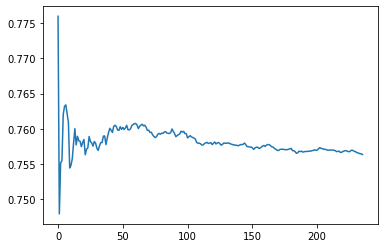

Train Epoch: 4	score:0.756378	准确率：93.59%
[1669/1670 (100%)]	正确分类的样本数：35048，样本总数：40080，准确率：87.45%，score：0.6897897321683951
epoch: 4_执行时间:  1118.1975283622742
_________________________________________________________________
_________________________________________________________________
_________________ epoch:4 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:5 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:2')
pred: tensor([[0.000

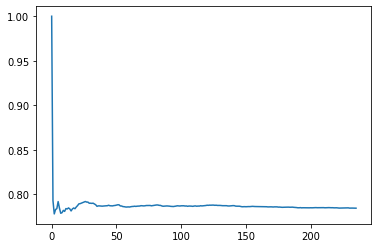

Train Epoch: 5	score:0.784467	准确率：94.96%
[1669/1670 (100%)]	正确分类的样本数：35116，样本总数：40080，准确率：87.61%，score：0.6893548866127478
epoch: 5_执行时间:  902.9930708408356
_________________________________________________________________
_________________________________________________________________
_________________ epoch:5 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:6 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]],
       device='cuda:2')
pred: tensor([[6.2039

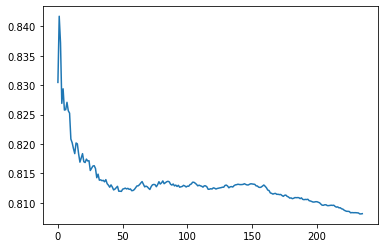

Train Epoch: 6	score:0.808162	准确率：96.05%
[1669/1670 (100%)]	正确分类的样本数：34705，样本总数：40080，准确率：86.59%，score：0.6769805005727243
epoch: 6_执行时间:  789.4936666488647
_________________________________________________________________
_________________________________________________________________
_________________ epoch:6 end _________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________
_________________ epoch:7 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       device='cuda:2')
pred: tensor([[2.2075

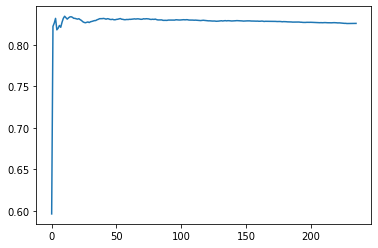

Train Epoch: 7	score:0.825871	准确率：96.78%
[1669/1670 (100%)]	正确分类的样本数：34626，样本总数：40080，准确率：86.39%，score：0.6788873348487405
epoch: 7_执行时间:  859.6982939243317
_________________________________________________________________
_________________________________________________________________
_________________ epoch:7 end _________________
_________________________________________________________________
_________________________________________________________________


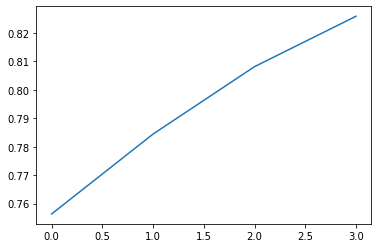

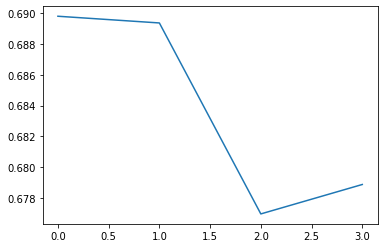

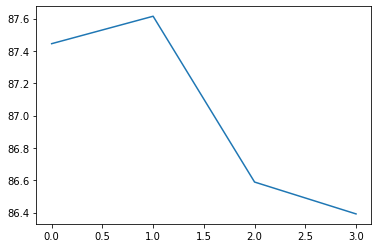

In [28]:
import time  # 引入time模块
 

import torch
import matplotlib.pyplot as plt

def train(device_train,device_test,epoch_be=0):
    epoch_num=4
    accumulation_steps=32
    
    train_score=[]
    test_score=[]
    test_acc=[]

    for epoch_idx in range(epoch_be,epoch_be+epoch_num):
        cls.to(device_train)
        print("_________________________________________________________________")
        print("_________________________________________________________________")
        print("_________________ epoch:"+str(epoch_idx)+" start _________________")
        print("_________________________________________________________________")
        print("_________________________________________________________________")
        score_list=[]
        loss_a=0
        total=0
        correct=0
        start = time.time()
        for batch_idx,batch in enumerate(train_loader):
            label=torch.stack(batch['label']).t().float().to(device_train)

            #计算output
            input_ids=torch.stack(batch['input_ids']).t().to(device_train)
            mask=torch.stack(batch['mask']).t().to(device_train)
            output = cls(input_ids, attention_mask=mask)

            # 梯度积累
            loss = criterion(output, label)
            loss = loss/accumulation_steps
            loss.backward()

            #计算score
            output=sigmoid(output)
        
            total += len(output)*6
            loss_add,cor_add = get_loss_test(output, label,round_=1)
            loss_a+=loss_add
            correct+=cor_add
        
            tr_score=1/(1+(loss_a/total) ** 0.5)
            acc_score=100.*correct/total


            if((batch_idx+1) % accumulation_steps) == 0:
                # 每 accumulation_steps 次更新一下网络中的参数
                optimizer.step()
                optimizer.zero_grad()

            if ((batch_idx+1) % accumulation_steps) == 1:
                score_list.append(tr_score)
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tscore:{:.6f}\t准确率：{:.2f}%'.format(
                    epoch_idx, batch_idx, len(train_loader), 
                    100.*batch_idx/len(train_loader), tr_score,acc_score
                ),end = "\r")

        #每个epoch结束：
        print('labels:', label)
        print('pred:', output)
        plt.plot([i for i in range(len(score_list))], score_list)
        plt.show()

        print('Train Epoch: {}\tscore:{:.6f}\t准确率：{:.2f}%'.format(epoch_idx,tr_score,acc_score))
        t_score,t_acc=test(device_test)

        train_score.append(tr_score)
        test_score.append(t_score)
        test_acc.append(t_acc)

        #保存模型
        end = time.time()
        print('epoch:',str(epoch_idx)+'_执行时间: ',end - start)
        torch.save(cls,"../data/cls_"+str(end)+"_"+str(epoch_idx)+"_"+str(round(tr_score,4))+"_"+str(round(t_score,4))+".model")

        print("_________________________________________________________________")
        print("_________________________________________________________________")
        print("_________________ epoch:"+str(epoch_idx)+" end _________________")
        print("_________________________________________________________________")
        print("_________________________________________________________________")

    plt.plot([i for i in range(len(train_score))], train_score)
    plt.show()             

    plt.plot([i for i in range(len(test_score))], test_score)
    plt.show()

    plt.plot([i for i in range(len(test_acc))], test_acc)
    plt.show()
    
train(device0,device1,epoch_be=4)


In [ ]:
# import torch
# end = time.time()
# torch.save(cls,"../data/cls_"+str(end)+"_"+str(epoch_idx)+"_"+str(round(tr_score,4))+".model")

In [23]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

def get_output(device_pre,model,text,f=0):
    model.to(device_pre)
    model.eval()
    text2id = tokenizer(
        text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
#     print(text,text2id)
    input_ids=text2id["input_ids"].to(device_pre)
    mask=text2id["attention_mask"].to(device_pre)
#         print(text2id)
    output = model(input_ids, attention_mask=mask)
    print(output)
    output=sigmoid(output)
    
#     output=sigmoid(output)*4
    if f==1:
        return _18to6_(output,round_=1)
    else:
        return _18to6_(output,round_=0)

In [24]:
text = ['*与n3：啊？']
# 爱、乐、惊、怒、恐、哀
print(get_output(device1,cls,text,1))

tensor([[-5.9895, -5.5591, -5.2792, -5.8290, -5.3601, -3.7367, -3.1285, -1.2139,
          0.4192, -5.6140, -4.8177, -3.6521, -5.4986, -3.8321, -2.9453, -5.6958,
         -3.9866, -3.3876]], device='cuda:7', grad_fn=<AddmmBackward0>)
[[0, 0, 1, 0, 0, 0]]
